  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   

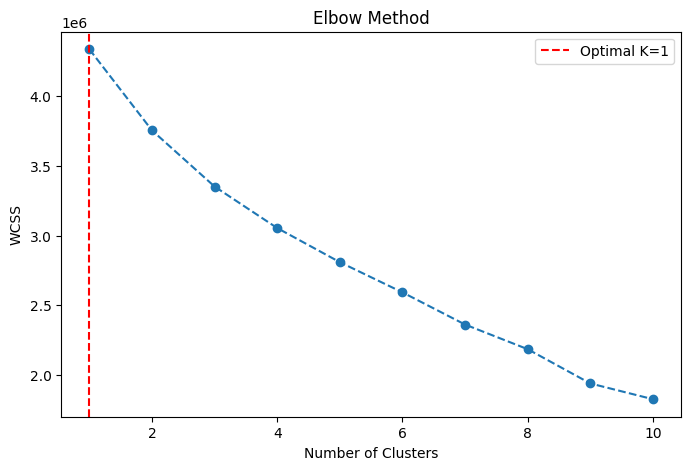

Error applying KMeans: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Clustered data saved successfully!


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

# Function to load data
def load_data(file_path):
    """Load and display initial information about the dataset."""
    try:
        df = pd.read_csv(file_path, encoding='latin1')  
        print(df.head())
        print(df.info())
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Function to preprocess data
def preprocess_data(df):
    """Preprocess data by handling missing values, encoding, and scaling."""
    df.drop(columns=["Customer ID"], inplace=True, errors='ignore')

    imputer = SimpleImputer(strategy='mean') 
    df[df.select_dtypes(include=['number']).columns] = imputer.fit_transform(df.select_dtypes(include=['number']))

    categorical_cols = df.select_dtypes(include=['object']).columns
    print(f"Categorical Columns: {list(categorical_cols)}")

    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str)) 
        label_encoders[col] = le

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    return df, scaled_data, scaler, label_encoders, imputer

def find_optimal_clusters(scaled_data):
    """Use the Elbow Method to determine the optimal number of clusters."""
    wcss = []
    try:
        for i in range(1, 11):  
            kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42, n_init=10, max_iter=200)
            kmeans.fit(scaled_data)
            wcss.append(kmeans.inertia_)

        # Plot Elbow Method
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
        plt.xlabel('Number of Clusters')
        plt.ylabel('WCSS')
        plt.title('Elbow Method')

        # Automatically determine the optimal number of clusters
        diffs = np.diff(wcss)
        optimal_clusters = np.argmin(diffs) + 1  
        print(f"Optimal number of clusters: {optimal_clusters}")

        plt.axvline(optimal_clusters, linestyle='--', color='red', label=f'Optimal K={optimal_clusters}')
        plt.legend()
        plt.show()

        return optimal_clusters
    except Exception as e:
        print(f"Error determining optimal clusters: {e}")
        return 3  

# Function to apply K-Means Clustering
def apply_kmeans(scaled_data, df, n_clusters):
    """Apply KMeans clustering and return the clustered data."""
    try:
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=10, max_iter=200)
        df["Cluster"] = kmeans.fit_predict(scaled_data)

        cluster_labels = df["Cluster"].values
        if np.all(np.isin(cluster_labels, range(n_clusters))):
            # Calculate silhouette score
            silhouette_avg = silhouette_score(scaled_data, df["Cluster"])
            print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg:.3f}")
        else:
            print("Cluster labels are not valid for silhouette score calculation.")
            silhouette_avg = None

        return df, kmeans
    except Exception as e:
        print(f"Error applying KMeans: {e}")
        return df, None

# Function to visualize clusters using PCA
def visualize_clusters(df, scaled_data):
    """Visualize clusters using PCA for dimensionality reduction."""
    try:
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(scaled_data)
        df["PCA1"], df["PCA2"] = pca_data[:, 0], pca_data[:, 1]

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x="PCA1", y="PCA2", hue=df["Cluster"], palette="viridis", data=df)
        plt.title("Customer Segmentation Clusters (PCA Reduced)")
        plt.legend(title="Cluster")
        plt.show()
    except Exception as e:
        print(f"Error visualizing clusters: {e}")

# Main Execution
if __name__ == "__main__":
    file_path = "C:/Users/deepi/Downloads/customer_data.csv"  
    df = load_data(file_path)

    if df is not None:
        df, scaled_data, scaler, label_encoders, imputer = preprocess_data(df)

        # Determine optimal clusters using the Elbow Method
        optimal_k = find_optimal_clusters(scaled_data)

        # Apply KMeans with optimal clusters
        df, kmeans = apply_kmeans(scaled_data, df, n_clusters=optimal_k)
        
        # Visualize clusters
        if kmeans is not None:
            visualize_clusters(df, scaled_data)

        # Save the clustered data
        df.to_csv("clustered_customer_data.csv", index=False)
        print("Clustered data saved successfully!")
